In [ ]:
!pip install easyfsl

In [2]:
print("hi")
#from easyfsl.samplers import TaskSampler
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path
import random
from statistics import mean
from sklearn import preprocessing

import torch
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split #to do
from sklearn.preprocessing import OrdinalEncoder
#import seaborn as sns #vis
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torchvision
from torch.optim import Adam
from tqdm import tqdm
import random
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
random_seed = 2023
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
batch_size = 2**9 #2**15
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()
x=df.drop("Class",axis=1)
y=df["Class"]
y[y==1].count()
X_train, X_test, y_train, y_test = train_test_split(x, y,
    test_size=0.4, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
    test_size=0.5, random_state= 8) # 0.25 x 0.8 = 0.2
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))
print(y_train[y_train==1].count())
print(y_val[y_val==1].count())
print(y_test[y_test==1].count())
x = X_train.values  # Input values.
y = y_train.values    # Output values(species categories)
xv=X_val.values
yv=y_val.values

#x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)
xv = min_max_scaler.fit_transform(xv)
#df = pd.DataFrame(x_scaled)

x_train = torch.FloatTensor(x)
y_train = torch.tensor(y)
x_val= torch.FloatTensor(xv)
y_val = torch.tensor(yv)
x_train_reshaped=x_train.reshape(170884,1,1,30).expand(-1,3,-1,-1)
x_val_reshaped=x_val.reshape(56962,1,1,30).expand(-1,3,-1,-1)
x_val_reshaped.shape


hi
X_train shape: (170884, 30)
y_train shape: (170884,)
X_test shape: (56961, 30)
y_test shape: (56961,)
X_val shape: (56962, 30)
y val shape: (56962,)
278
108
106


torch.Size([56962, 3, 1, 30])

In [ ]:
n_way = 2
n_shot = 50
n_query = 50
n_tasks_per_epoch = 1000
n_validation_tasks = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_workers = 2

In [5]:
import random
from typing import List, Tuple, Iterator

import torch
from torch import Tensor
from torch.utils.data import Sampler

from easyfsl.datasets import FewShotDataset


class TaskSampler(Sampler):
    """
    Samples batches in the shape of few-shot classification tasks. At each iteration, it will sample
    n_way classes, and then sample support and query images from these classes.
    """

    def __init__(
        self,
        dataset: FewShotDataset,
        n_way: int,
        n_shot: int,
        n_query: int,
        n_tasks: int,
    ):
        """
        Args:
            dataset: dataset from which to sample classification tasks. Must have a field 'label': a
                list of length len(dataset) containing containing the labels of all images.
            n_way: number of classes in one task
            n_shot: number of support images for each class in one task
            n_query: number of query images for each class in one task
            n_tasks: number of tasks to sample
        """
        super().__init__(data_source=None)
        self.n_way = n_way
        self.n_shot = n_shot
        self.n_query = n_query
        self.n_tasks = n_tasks

        self.items_per_label = {}
        for item, label in enumerate(dataset.get_labels()):
            if label in self.items_per_label.keys():
                self.items_per_label[label].append(item)
            else:
                self.items_per_label[label] = [item]

    def __len__(self) -> int:
        return self.n_tasks

    def __iter__(self) -> Iterator[List[int]]:
        for _ in range(self.n_tasks):
            yield torch.cat(
                [
                    # pylint: disable=not-callable
                    torch.tensor(
                        random.sample(
                            self.items_per_label[label], self.n_shot + self.n_query
                        )
                    )
                    # pylint: enable=not-callable
                    for label in random.sample(self.items_per_label.keys(), self.n_way)
                ]
            ).tolist()

    def episodic_collate_fn(
        self, input_data: List[Tuple[Tensor, int]]
    ) -> Tuple[Tensor, Tensor, Tensor, Tensor, List[int]]:
        """
        Collate function to be used as argument for the collate_fn parameter of episodic
            data loaders.
        Args:
            input_data: each element is a tuple containing:
                - an image as a torch Tensor
                - the label of this image
        Returns:
            tuple(Tensor, Tensor, Tensor, Tensor, list[int]): respectively:
                - support images,
                - their labels,
                - query images,
                - their labels,
                - the dataset class ids of the class sampled in the episode
        """
        #the input_data should be a list
        if not isinstance(input_data, list):
            raise TypeError(
                "Illegal type of input."
                "check the type of the output of the .getitem() method of your dataset and make sure it's a List[Tuple[Tensor, int]] or List[Tuple[Tensor, 0-dim Tensor]]."
            )
        #the instances inside the input_data list should be all Tuples
        if not all(isinstance(n, tuple) for n in input_data):
            raise TypeError(
                "Illegal type of input."
                "check the type of the output of the .getitem() method of your dataset and make sure it's a List[Tuple[Tensor, int]] or List[Tuple[Tensor, 0-dim Tensor]]."
            )
        #inside the tuple there should be  List[Tuple[Tensor, int]] or List[Tuple[Tensor, 0-dim Tensor]]
        if not all( isinstance(n[0],torch.Tensor) and isinstance(n[1],int) for n in input_data):
            if not all( isinstance(n[0],torch.Tensor) and isinstance(n[1],torch.Tensor) and n[1].ndim==0 for n in input_data):
                raise TypeError(
                "Illegal type of input."
                "check the type of the output of the .getitem() method of your dataset and make sure it's a List[Tuple[Tensor, int]] or List[Tuple[Tensor, 0-dim Tensor]]."
                )
            #if the input is List[Tuple[Tensor, 0-dim Tensor]], turn the tensor into an int
            else:
                for i in range(len(input_data)):
                    input_data[i]=(input_data[i][0],int(input_data[i][1]))
                             
        true_class_ids = list({x[1] for x in input_data})

        all_images = torch.cat([x[0].unsqueeze(0) for x in input_data])
        all_images = all_images.reshape(
            (self.n_way, self.n_shot + self.n_query, *all_images.shape[1:])
        )
        # pylint: disable=not-callable
        all_labels = torch.tensor(
            [true_class_ids.index(x[1]) for x in input_data]
        ).reshape((self.n_way, self.n_shot + self.n_query))
        # pylint: enable=not-callable

        support_images = all_images[:, : self.n_shot].reshape(
            (-1, *all_images.shape[2:])
        )
        query_images = all_images[:, self.n_shot :].reshape((-1, *all_images.shape[2:]))
        support_labels = all_labels[:, : self.n_shot].flatten()
        query_labels = all_labels[:, self.n_shot :].flatten()

        return (
            support_images,
            support_labels,
            query_images,
            query_labels,
            true_class_ids,
        )


In [6]:
train_set = data_utils.TensorDataset(x_train_reshaped, y_train)
train_set.get_labels = lambda:  [ y.item() for y in y_train]
val_set = data_utils.TensorDataset(x_val_reshaped, y_val)
val_set.get_labels = lambda:  [ y.item() for y in y_val]

In [7]:
labels=train_set.__getitem__(1)
type(labels[1])

torch.Tensor

In [8]:
train_sampler = TaskSampler(
    train_set, n_way=n_way, n_shot=100, n_query=100, n_tasks=n_tasks_per_epoch
)
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

In [9]:
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    #num_workers=n_workers,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    #num_workers=n_workers,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

In [ ]:
#from easyfsl.methods import RelationNetworks
from torchvision.models import  resnet18,ResNet18_Weights
backbone=resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
backbone = torch.nn.Sequential(*(list(backbone.children())[:-1]))
backbone.train()

In [19]:

def default_relation_module(feature_dimension: int, inner_channels: int = 8):
    """
    Build the relation module that takes as input the concatenation of two feature maps, from
    Sung et al. : "Learning to compare: Relation network for few-shot learning." (2018)
    In order to make the network robust to any change in the dimensions of the input images,
    we made some changes to the architecture defined in the original implementation
    from Sung et al.(typically the use of adaptive pooling).
    Args:
        feature_dimension: the dimension of the feature space i.e. size of a feature vector
        inner_channels: number of hidden channels between the linear layers of  the relation module

    Returns:
        the constructed relation module
    """
    return nn.Sequential(
        nn.Sequential(
            nn.Conv2d(
                feature_dimension * 2,
                feature_dimension,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(feature_dimension, momentum=1, affine=True),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool2d((5, 5)),
        ),
        nn.Sequential(
            nn.Conv2d(
                feature_dimension,
                feature_dimension,
                kernel_size=3,
                padding=0,
            ),
            nn.BatchNorm2d(feature_dimension, momentum=1, affine=True),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool2d((1, 1)),
        ),
        nn.Flatten(),
        nn.Linear(feature_dimension, inner_channels),
        nn.ReLU(),
        nn.Linear(inner_channels, 1),
        #nn.Sigmoid(),
    )

In [20]:
import torch
from torch import nn, Tensor
from easyfsl.methods import FewShotClassifier
#from easyfsl.modules.predesigned_modules import default_relation_module
from easyfsl.utils import compute_prototypes


class RelationNetworks(nn.Module):
   
    def __init__(self,backbone: nn.Module, use_softmax: bool = False, *args, relation_module: nn.Module = None, **kwargs):
        """
        Build Relation Networks by calling the constructor of FewShotClassifier.
        Args:
            relation_module: module that will take the concatenation of a query features vector
                and a prototype to output a relation score. If none is specific, we use the default
                relation module from the original paper.
        """
        super().__init__()

        self.backbone = backbone
        self.feature_dimension = 512

        self.use_softmax = use_softmax

        self.prototypes = None
        self.support_features = None
        self.support_labels = None        
        # Here we build the relation module that will output the relation score for each
        # (query, prototype) pair. See the function docstring for more details.
        self.relation_module = (
            relation_module
            if relation_module
            else default_relation_module(self.feature_dimension)
        )

    def process_support_set(
        self,
        support_images: Tensor,
        support_labels: Tensor,
    ):
        """
        Overrides process_support_set of FewShotClassifier.
        Extract feature maps from the support set and store class prototypes.

        Args:
            support_images: images of the support set
            support_labels: labels of support set images
        """

        support_features = self.backbone(support_images)
        self.prototypes = compute_prototypes(support_features, support_labels)

    def forward(self, query_images: Tensor) -> Tensor:
        """
        Overrides method forward in FewShotClassifier.
        Predict the label of a query image by concatenating its feature map with each class
        prototype and feeding the result into a relation module, i.e. a CNN that outputs a relation
        score. Finally, the classification vector of the query is its relation score to each class
        prototype.

        Args:
            query_images: images of the query set
        Returns:
            a prediction of classification scores for query images
        """
        query_features = self.backbone(query_images)

        # For each pair (query, prototype), we compute the concatenation of their feature maps
        # Given that query_features is of shape (n_queries, n_channels, width, height), the
        # constructed tensor is of shape (n_queries * n_prototypes, 2 * n_channels, width, height)
        # (2 * n_channels because prototypes and queries are concatenated)
        query_prototype_feature_pairs = torch.cat(
            (
                self.prototypes.unsqueeze(dim=0).expand(
                    query_features.shape[0], -1, -1, -1, -1
                ),
                query_features.unsqueeze(dim=1).expand(
                    -1, self.prototypes.shape[0], -1, -1, -1
                ),
            ),
            dim=2,
        ).view(-1, 2 * self.feature_dimension, *query_features.shape[2:])

        # Each pair (query, prototype) is assigned a relation scores in [0,1]. Then we reshape the
        # tensor so that relation_scores is of shape (n_queries, n_prototypes).
        relation_scores = self.relation_module(query_prototype_feature_pairs).view(
            -1, self.prototypes.shape[0]
        )

        return relation_scores

    @staticmethod
    def is_transductive() -> bool:
        return False
few_shot_classifier1 = RelationNetworks(backbone).to(device)

512


In [80]:
from torch.optim import SGD, Optimizer,Adam
from torch.optim.lr_scheduler import MultiStepLR
#from torch.utils.tensorboard import SummaryWriter


LOSS_FUNCTION = nn.CrossEntropyLoss()

n_epochs = 5000
scheduler_milestones = [120, 160]
scheduler_gamma = 0.1
learning_rate = .01
tb_logs_dir = Path(".")

train_optimizer = SGD(
    few_shot_classifier1.parameters(), lr=learning_rate
)
train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)

#tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))

In [22]:


def training_epoch(
    model, data_loader: DataLoader, optimizer: Optimizer
):
    all_loss = []
    model.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            true_class_IDs ,
        ) in tqdm_train:
            optimizer.zero_grad()
            model.process_support_set(support_images.to(device), support_labels.to(device))
            #model.process_query_set(query_images.to(device), query_labels.to(device))
            #print(torch.isnan(query_images).sum())#torch.isnan(torch.tensor([1, float('nan'), 2])).sum()
            classification_scores = model(query_images.to(device))
            #print("classification_scores ",classification_scores)
            #print("query_labels ",query_labels)
            #print("true_class_IDs ",true_class_IDs)
            #that string is what fix that erorr
            """for i in range(len(query_labels)):
                if query_labels[i] !=0:
                    query_labels[i]=1"""
            #print("classification_scores ",classification_scores)
            loss = LOSS_FUNCTION(classification_scores, query_labels.to(device))
            all_loss.append(loss.item())
            loss.backward()
            optimizer.step()

            

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)



In [23]:
best_state = few_shot_classifier1.state_dict()
best_validation_accuracy = 0.6

In [ ]:
from easyfsl.methods.utils import evaluate

print("I'm not dead")
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(few_shot_classifier1, train_loader, train_optimizer)
    validation_accuracy = evaluate(
        few_shot_classifier1, val_loader, device=device, tqdm_prefix="Validation"
    )
    print(validation_accuracy)
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = few_shot_classifier1.state_dict()
        print("Ding ding ding! We found a new best model!")
        torch.save(few_shot_classifier1,"checkpoint1.pth")
    #tb_writer.add_scalar("Train/loss", average_loss, epoch)
    #tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    train_scheduler.step()
    

In [83]:
def load_test(
    model, data_loader: DataLoader
):
    all_loss = []
    model.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            true_class_IDs ,
        ) in tqdm_train:
            model.process_support_set(support_images.to(device), support_labels.to(device))
load_test(
    few_shot_classifier1, train_loader
)

Training: 100%|██████████| 1000/1000 [00:15<00:00, 64.11it/s]


In [49]:
y_test[y_test==1]
yt= torch.FloatTensor(y_test.values)
#!pip install torchmetrics

In [ ]:
yt.shape

In [ ]:
device="cuda"
results=np.zeros(56961)
#few_shot_classifier=torch.load("/kaggle/input/model-param/checkpoint1 (3).pth")
#few_shot_classifier.to(device)


few_shot_classifier1.eval()
torch.cuda.empty_cache()
batch_size=7120
start =0
end=1
for i in range(int(56961/7120)):
    pred=few_shot_classifier1(torch.FloatTensor(min_max_scaler.fit_transform(X_test[batch_size*i:batch_size*(i+1)].values)).reshape(batch_size,1,1,30).expand(-1,3,-1,-1).to(device))
    results[batch_size*i:batch_size*(i+1)]=pred.data.argmax(1).cpu().numpy()

In [85]:
from sklearn.metrics import f1_score   
print("f1_score = ",f1_score(yt.numpy(), results))
from sklearn.metrics import average_precision_score, roc_auc_score
print("roc_auc_score = ",roc_auc_score(yt.numpy(), results))


f1_score =  0.6961325966850828
roc_auc_score =  0.7970642797052416


In [86]:
from sklearn.metrics import average_precision_score
average_precision_score(yt.numpy(), results)

0.5000001854960013

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
confusion_matrix(yt.numpy(), results)

array([[56843,    12],
       [   43,    63]])

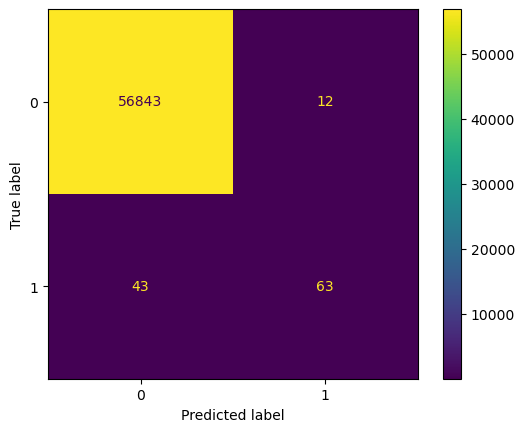

In [88]:
disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(target.numpy(), results))
disp.plot()
plt.show()